In [1]:
import cv2
from PIL import Image
import numpy as np
import uuid
import os
from tqdm import tqdm
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(os.path.dirname(os.getcwd())+"/dataset/Video Information Extraction.csv")

In [3]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,0,63047,39,13,248,192,wheelchair
11976,25,-1,1,8,12,aslsearch,train,http://www.aslsearch.com/signs/videos/wheelcha...,0,63050,163,62,625,400,wheelchair
11977,25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,76,17,236,240,whistle
11978,25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,68,14,212,192,whistle


## Open a video

In [4]:
video_path = os.path.dirname(os.getcwd())+"\\dataset\\videos\\"
id_video = 1652

In [5]:
cap = cv2.VideoCapture(video_path + str(df["video_id"][id_video]).zfill(5)+".mp4")
frame_count = 1

frame_start = df["frame_start"][id_video]
frame_end =  df["frame_end"][id_video]
x1,y1,x2,y2 = df["bbox_xmin"][id_video], df["bbox_ymin"][id_video], df["bbox_xmax"][id_video], df["bbox_ymax"][id_video]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret :
        if (frame_count >= frame_start) and ((frame_end == -1) or (frame_end >= frame_count)):
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.imshow('frame',frame)
    else:
        break
    frame_count += 1
    if cv2.waitKey(20) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

### Create the numpy dataset

In [6]:
def convert_image_numpy(filename) :
    cap = cv2.VideoCapture(filename)
    img = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        
        if ret:
            frame = cv2.resize(frame, (64, 64))
            img.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.array(img)

In [7]:
test_img = convert_image_numpy(video_path + str(df["video_id"][id_video]).zfill(5)+".mp4")

In [8]:
video_record = {}
for video_id in tqdm(df["video_id"]):
    video_record[video_id] = convert_image_numpy(video_path + str(video_id).zfill(5)+".mp4")

100%|████████████████████████████████████████████████████████████████████████████| 11980/11980 [12:15<00:00, 16.29it/s]


## Analysing sequences length

In [9]:
len_sequence_video= np.array([len(seq) for seq in video_record.values()])

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

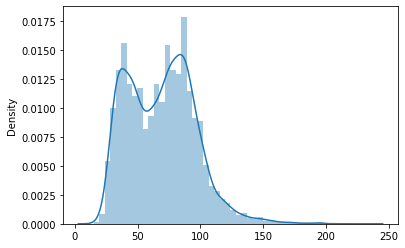

In [10]:
sns.distplot(len_sequence_video)

In [11]:
len(len_sequence_video[len_sequence_video < 30])/len(len_sequence_video)

0.03772954924874791

3% of the dataset contains sequence less than 30 images to depict a sign. 

In [12]:
keys_dict = list(video_record.keys())

In [13]:
cleaned_video_record = { keys_dict[id_key] : video_record[keys_dict[id_key]] for id_key in np.where(len_sequence_video >= 30)[0]}

In [14]:
len(cleaned_video_record)

11528

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

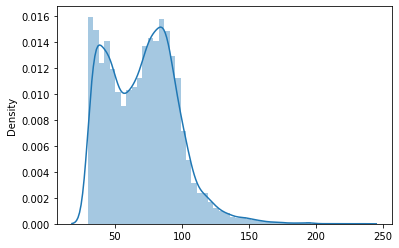

In [15]:
len_sequence_video_detected = np.array([len(seq) for seq in cleaned_video_record.values()])
sns.distplot(len_sequence_video_detected)

In [16]:
left_keys_dict = list(cleaned_video_record.keys())

In [17]:
new_df = df.copy()
new_df = new_df[new_df["video_id"].isin(left_keys_dict)]

In [18]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,0,63047,39,13,248,192,wheelchair
11976,25,-1,1,8,12,aslsearch,train,http://www.aslsearch.com/signs/videos/wheelcha...,0,63050,163,62,625,400,wheelchair
11977,25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,76,17,236,240,whistle
11978,25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,68,14,212,192,whistle


In [19]:
word_freq = dict(new_df["gloss"].value_counts())

In [20]:
freq = np.array(list(word_freq.values()))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

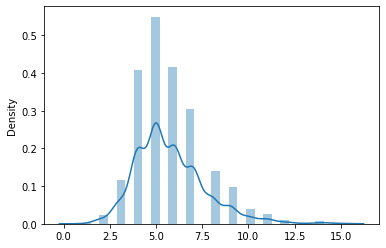

In [21]:
sns.distplot(freq)

In [22]:
print(len(freq[freq < 4])/len(freq))

0.066

In [23]:
kept_gloss = list(word_freq.keys())[:np.where(freq < 4)[0][0]]
new_df = new_df[new_df["gloss"].isin(kept_gloss)]

In [24]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11969,25,-1,1,6,12,aslsearch,train,http://www.aslsearch.com/signs/videos/waterfal...,0,62493,203,55,549,400,waterfall
11973,25,-1,1,2,4,signschool,test,https://signstock.blob.core.windows.net/signsc...,0,63044,415,86,1811,1080,wheelchair
11974,25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/4/4101.mp4,0,63046,35,10,259,192,wheelchair
11975,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,0,63047,39,13,248,192,wheelchair


In [25]:
word_freq = dict(new_df["gloss"].value_counts())

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

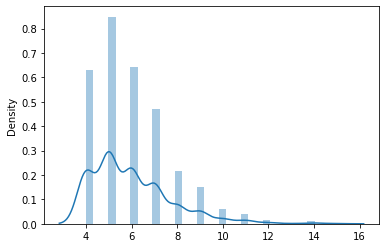

In [26]:
freq = np.array(list(word_freq.values()))
sns.distplot(freq)

In [27]:
final_video_record = {key : video_record[key] for key in sorted(new_df["video_id"])}

In [28]:
len(final_video_record)

11157

In [29]:
new_df = new_df.sort_values(by='video_id')

In [19]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(np.array(list(new_df["gloss"])).reshape(-1,1))

le = LabelEncoder()
le.fit(np.array(list(new_df["gloss"])))

LabelEncoder()

In [20]:
pickle.dump(encoder, open("one hot encoder", 'wb'))
pickle.dump(le, open("label encoder", 'wb'))

In [30]:
new_df.to_csv("Extraction cleaned")

## Construct all videos with the same number of sequence

Has it will be feed to a deep neural network, we need to have a fixed number of sequence for each record. To do that, a linear interpolation.

In [31]:
number_of_sequences = 64

In [32]:
all_sequences = list(final_video_record.values())

In [33]:
len(all_sequences)

11157

In [34]:
all_sequences[0].shape

(58, 64, 64, 3)

In [35]:
def linear_interpolation(video, number_of_sequences):
    '''
        Linear interpolation
    '''
    
    flatten_video = video.reshape(video.shape[0], -1)
    interpolated_video = np.zeros(shape = (flatten_video.shape[1], number_of_sequences))
    
    current_nb_seq = np.linspace(0, 1, flatten_video.shape[0])
    new_seq = np.linspace(0, 1, number_of_sequences)
    
    for count, pixel in enumerate(flatten_video.T):
        f = interpolate.interp1d(current_nb_seq, pixel)
        interpolated_video[count] = f(new_seq)
    interpolated_video = interpolated_video.T
    return interpolated_video.reshape(number_of_sequences, video.shape[1], video.shape[2], video.shape[3])

In [36]:
test = linear_interpolation(all_sequences[0], number_of_sequences)

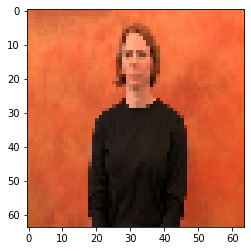

In [37]:
plt.imshow(test[-1]/255)

In [38]:
test.shape

(64, 64, 64, 3)

In [39]:
final_numpy_record = []
for key_record, values_records in tqdm(final_video_record.items()):
    final_numpy_record.append(np.array(linear_interpolation(values_records, number_of_sequences)/255, dtype="float32"))

100%|██████████████████████████████████████████████████████████████████████████| 11157/11157 [1:31:10<00:00,  2.04it/s]


In [61]:
final_numpy_record[0].shape

(64, 64, 64, 3)

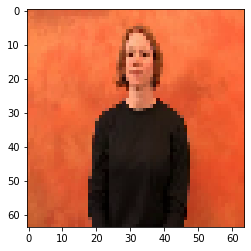

In [42]:
plt.imshow(final_numpy_record[0][0])

In [2]:
final_numpy_record = joblib.load("final_record_cleaned.pkl")
new_df = pd.read_csv("Extraction cleaned", header = 0, index_col=0)

In [3]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
8751,25,-1,1,2,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,335,57,5,246,240,abdomen
8752,25,-1,1,3,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14688...,0,336,103,0,565,480,abdomen
8753,25,-1,1,5,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/23/2386...,0,338,68,14,214,192,abdomen
8754,25,-1,1,6,10,signingsavvy,val,https://www.signingsavvy.com/signs/mp4/23/2386...,0,339,60,13,211,192,abdomen
8755,25,-1,1,8,12,aslsearch,train,http://www.aslsearch.com/signs/videos/abdomen.mp4,0,341,190,46,571,400,abdomen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10279,25,-1,1,0,117,aslbrick,val,http://aslbricks.org/New/ASL-Videos/wrap.mp4,0,69542,385,33,1003,720,wrap
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow
201,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/yes.mp4,0,69546,214,41,881,720,yes


In [4]:
word_freq = dict(new_df["gloss"].value_counts())
freq = np.array(list(word_freq.values()))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

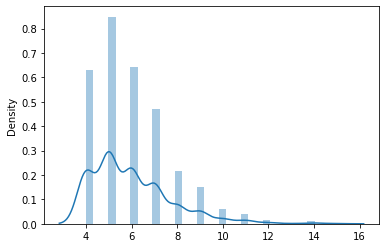

In [5]:
sns.distplot(freq)

In [6]:
print(len(freq[freq >= 10])/len(freq), len(freq[freq >= 10]))

0.042826552462526764 80


### If we keep all the words that are present more than 4 times

In [7]:
skf = StratifiedKFold(n_splits=2)
skf2 = StratifiedKFold(n_splits=2)
train_index, test_index = skf.split(final_numpy_record, list(new_df["gloss"]))
train_index = train_index[0]
test_index = test_index[0]

df_split1 = new_df.iloc[train_index]
df_split2 = new_df.iloc[test_index]

train_index2, test_index2 = skf2.split([final_numpy_record[i] for i in train_index], list(df_split1["gloss"]))
fold1 = df_split1.iloc[train_index2[0]]["video_id"]
fold2 = df_split1.iloc[test_index2[0]]["video_id"]

train_index2, test_index2 = skf2.split([final_numpy_record[i] for i in test_index], list(df_split2["gloss"]))
fold3 = df_split2.iloc[train_index2[0]]["video_id"]
fold4 = df_split2.iloc[test_index2[0]]["video_id"]

index_video_id = list(new_df["video_id"])

fold1 = [index_video_id.index(video_id) for video_id in fold1]
fold2 = [index_video_id.index(video_id) for video_id in fold2]
fold3 = [index_video_id.index(video_id) for video_id in fold3]
fold4 = [index_video_id.index(video_id) for video_id in fold4]

In [11]:
for id_df in [fold1, fold2, fold3, fold4]:
    df = new_df.iloc[id_df]
    print(len(dict(new_df["gloss"].value_counts())))

1868
1868
1868
1868


In [16]:
for num_fold, fold in enumerate([fold1, fold2, fold3, fold4]):
    joblib.dump([final_numpy_record[i] for i in fold], 'Kfold/Video numpy/' + str(num_fold) + '.pkl', compress = 3)
    new_df.iloc[fold].to_csv('Kfold/Dataframe/' + str(num_fold))

### If we keep all the words that are present more than 9 times

In [7]:
gloss_name = [list(word_freq.keys())[i] for i in np.where(freq >= 10)[0]]

In [8]:
final_df = new_df[new_df["gloss"].isin(gloss_name)]

In [9]:
word_freq = dict(final_df["gloss"].value_counts())
freq = np.array(list(word_freq.values()))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

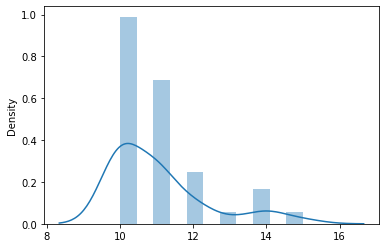

In [10]:
sns.distplot(freq)

In [11]:
final_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
558,25,-1,1,4,32,signschool,val,https://signstock.blob.core.windows.net/signsc...,0,626,485,85,1608,1080,accident
559,25,-1,1,5,6,signschool,val,https://signstock.blob.core.windows.net/signsc...,1,627,662,54,1434,1080,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,25,-1,1,1,115,aslbrick,train,http://aslbricks.org/New/ASL-Videos/take.mp4,0,69500,166,43,952,720,take
334,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/what.mp4,1,69531,155,34,1067,720,what
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


In [12]:
reduced_encoder = OneHotEncoder(handle_unknown='ignore')
reduced_encoder.fit(np.array(list(final_df["gloss"])).reshape(-1,1))

reduced_le = LabelEncoder()
reduced_le.fit(np.array(list(final_df["gloss"])))

LabelEncoder()

In [13]:
pickle.dump(reduced_encoder, open("reduced one hot encoder", 'wb'))
pickle.dump(reduced_le, open("reduced label encoder", 'wb'))

In [14]:
final_index = final_df.index.values.tolist()

In [15]:
joblib.dump([final_numpy_record[i] for i in final_index], 'reduced_numpy_videos.pkl', compress = 3)
final_df.to_csv('reduced_dataset.csv')